## TWRI

This problem is described in McDonald and Harbaugh (1988) and duplicated in
Harbaugh and McDonald (1996). This problem is also is distributed with
MODFLOW-2005 (Harbaugh, 2005) and MODFLOW 6 (Langevin and others, 2017).

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-twri01"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Scenario parameter units - make sure there is at least one blank line before next item
# add parameter_units to add units to the scenario parameter table
parameter_units = {"recharge": "$ft/s$"}

# Model units
length_units = "feet"
time_units = "seconds"

# Model parameters
nper = 1  # Number of periods
nlay = 5  # Number of layers
ncol = 15  # Number of columns
nrow = 15  # Number of rows
delr = 5000.0  # Column width ($ft$)
delc = 5000.0  # Row width ($ft$)
top = 200.0  # Top of the model ($ft$)
botm_str = "-150.0, -200.0, -300.0, -350.0, -450.0"  # Layer bottom elevations ($ft$)
strt = 0.0  # Starting head ($ft$)
icelltype_str = "1, 0, 0, 0, 0"  # Cell conversion type
k11_str = "1.0e-3, 1.0e-8, 1.0e-4, 5.0e-7, 2.0e-4"  # Horizontal hydraulic conductivity ($ft/s$)
k33_str = (
    "1.0e-3, 1.0e-8, 1.0e-4, 5.0e-7, 2.0e-4"  # Vertical hydraulic conductivity ($ft/s$)
)
recharge = 3e-8  # Recharge rate ($ft/s$)

# Static temporal data used by TDIS file
perlen = 8.640e04
nstp = 1
tsmult = 1.0
tdis_ds = ((perlen, nstp, tsmult),)

# parse parameter strings into tuples
botm = [float(value) for value in botm_str.split(",")]
k11 = [float(value) for value in k11_str.split(",")]
k33 = [float(value) for value in k33_str.split(",")]
icelltype = [int(value) for value in icelltype_str.split(",")]

# Create TWRI Model Boundary Conditions
# Constant head cells are specified on the west edge of the model
# in model layers 1 and 2 `(k, i, j)` = $(1 \rightarrow 2, 1 \rightarrow 15, 1)$
chd_spd = []
for k in (0, 2):
    chd_spd += [[k, i, 0, 0.0] for i in range(nrow)]
chd_spd = {0: chd_spd}

# Constant head cells for MODFLOW-2005 model
chd_spd0 = []
for k in (0, 1):
    chd_spd0 += [[k, i, 0, 0.0, 0.0] for i in range(nrow)]
chd_spd0 = {0: chd_spd0}

# Well boundary conditions
wel_spd = {
    0: [
        [4, 4, 10, -5.0],
        [2, 3, 5, -5.0],
        [2, 5, 11, -5.0],
        [0, 8, 7, -5.0],
        [0, 8, 9, -5.0],
        [0, 8, 11, -5.0],
        [0, 8, 13, -5.0],
        [0, 10, 7, -5.0],
        [0, 10, 9, -5.0],
        [0, 10, 11, -5.0],
        [0, 10, 13, -5.0],
        [0, 12, 7, -5.0],
        [0, 12, 9, -5.0],
        [0, 12, 11, -5.0],
        [0, 12, 13, -5.0],
    ]
}

# Well boundary conditions for MODFLOW-2005 model
wel_spd0 = []
layer_map = {0: 0, 2: 1, 4: 2}
for k, i, j, q in wel_spd[0]:
    kk = layer_map[k]
    wel_spd0.append([kk, i, j, q])
wel_spd0 = {0: wel_spd0}

# Drain boundary conditions
drn_spd = {
    0: [
        [0, 7, 1, 0.0, 1.0e0],
        [0, 7, 2, 0.0, 1.0e0],
        [0, 7, 3, 10.0, 1.0e0],
        [0, 7, 4, 20.0, 1.0e0],
        [0, 7, 5, 30.0, 1.0e0],
        [0, 7, 6, 50.0, 1.0e0],
        [0, 7, 7, 70.0, 1.0e0],
        [0, 7, 8, 90.0, 1.0e0],
        [0, 7, 9, 100.0, 1.0e0],
    ]
}

# Solver parameters
nouter = 50
ninner = 100
hclose = 1e-9
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models():
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        cvoptions="perched",
        perched=True,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chd_spd)
    flopy.mf6.ModflowGwfdrn(gwf, stress_period_data=drn_spd)
    flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wel_spd)
    flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    return sim


def build_mf5model():
    sim_ws = os.path.join(workspace, sim_name, "mf2005")
    mf = flopy.modflow.Modflow(
        modelname=sim_name, model_ws=sim_ws, exe_name="mf2005dbl"
    )
    flopy.modflow.ModflowDis(
        mf,
        nlay=3,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        laycbd=[1, 1, 0],
        top=top,
        botm=botm,
        nper=1,
        perlen=perlen,
        nstp=nstp,
        tsmult=tsmult,
    )
    flopy.modflow.ModflowBas(mf, strt=strt)
    flopy.modflow.ModflowLpf(
        mf,
        laytyp=[1, 0, 0],
        hk=[k11[0], k11[2], k11[4]],
        vka=[k11[0], k11[2], k11[4]],
        vkcb=[k11[1], k11[3], 0],
        ss=0,
        sy=0.0,
    )
    flopy.modflow.ModflowChd(mf, stress_period_data=chd_spd0)
    flopy.modflow.ModflowDrn(mf, stress_period_data=drn_spd)
    flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd0)
    flopy.modflow.ModflowRch(mf, rech=recharge)
    flopy.modflow.ModflowPcg(
        mf, mxiter=nouter, iter1=ninner, hclose=hclose, rclose=rclose
    )
    oc = flopy.modflow.ModflowOc(
        mf, stress_period_data={(0, 0): ["save head", "save budget"]}
    )
    oc.reset_budgetunit()
    return mf


def write_models(sim, mf, silent=True):
    sim.write_simulation(silent=silent)
    mf.write_input()


@timed
def run_models(sim, mf, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    if not success:
        print(buff)
    else:
        success, buff = mf.run_model(silent=silent)
        assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (6, 6)


def plot_results(sim, mf, silent=True):
    with styles.USGSMap():
        sim_ws = os.path.join(workspace, sim_name)
        gwf = sim.get_model(sim_name)

        # create MODFLOW 6 head object
        hobj = gwf.output.head()

        # create MODFLOW-2005 head object
        file_name = gwf.oc.head_filerecord.get_data()[0][0]
        fpth = os.path.join(sim_ws, "mf2005", file_name)
        hobj0 = flopy.utils.HeadFile(fpth)

        # create MODFLOW 6 cell-by-cell budget object
        cobj = gwf.output.budget()

        # create MODFLOW-2005 cell-by-cell budget object
        file_name = gwf.oc.budget_filerecord.get_data()[0][0]
        fpth = os.path.join(sim_ws, "mf2005", file_name)
        cobj0 = flopy.utils.CellBudgetFile(fpth, precision="double")

        # extract heads
        head = hobj.get_data()
        head0 = hobj0.get_data()
        print(head0.shape)
        vmin, vmax = -25, 100

        # check that the results are comparable
        for idx, k in enumerate(
            (
                0,
                2,
                4,
            )
        ):
            diff = np.abs(head[k] - head0[idx])
            msg = (
                "aquifer {}: ".format(idx + 1)
                + f"maximum absolute head difference is {diff.max()}"
            )
            assert diff.max() < 0.05, msg
            if not silent:
                print(msg)

        # extract specific discharge
        qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
            cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0],
            gwf,
        )
        frf = cobj0.get_data(text="FLOW RIGHT FACE", kstpkper=(0, 0))[0]
        fff = cobj0.get_data(text="FLOW FRONT FACE", kstpkper=(0, 0))[0]
        flf = cobj0.get_data(text="FLOW LOWER FACE", kstpkper=(0, 0))[0]
        sqx, sqy, sqz = flopy.utils.postprocessing.get_specific_discharge(
            (frf, fff, flf), mf, head0
        )

        # modflow 6 layers to extract
        layers_mf6 = [0, 2, 4]
        titles = ["Unconfined aquifer", "Middle aquifer", "Lower aquifer"]

        # Create figure for simulation
        extents = (0, ncol * delc, 0, nrow * delr)
        fig, axes = plt.subplots(
            2,
            3,
            figsize=figure_size,
            dpi=300,
            # constrained_layout=True,
            sharey=True,
        )
        for ax in axes.flatten():
            ax.set_aspect("equal")
            ax.set_xlim(extents[:2])
            ax.set_ylim(extents[2:])

        for idx, ax in enumerate(axes.flatten()[:3]):
            k = layers_mf6[idx]
            fmp = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=k, extent=extents)
            ax.get_xaxis().set_ticks([])
            fmp.plot_grid(lw=0.5)
            plot_obj = fmp.plot_array(head, vmin=vmin, vmax=vmax)
            fmp.plot_bc("DRN", color="green")
            fmp.plot_bc("WEL", color="0.5")
            cv = fmp.contour_array(
                head,
                levels=[-25, 0, 25, 75, 100],
                linewidths=0.5,
                colors="black",
            )
            plt.clabel(cv, fmt="%1.0f")
            fmp.plot_vector(qx, qy, normalize=True, color="0.75")
            title = titles[idx]
            letter = chr(ord("@") + idx + 1)
            styles.heading(letter=letter, heading=title, ax=ax)

        for idx, ax in enumerate(axes.flatten()[3:6]):
            fmp = flopy.plot.PlotMapView(model=mf, ax=ax, layer=idx, extent=extents)
            fmp.plot_grid(lw=0.5)
            plot_obj = fmp.plot_array(head0, vmin=vmin, vmax=vmax)
            fmp.plot_bc("DRN", color="green")
            fmp.plot_bc("WEL", color="0.5")
            cv = fmp.contour_array(
                head0,
                levels=[-25, 0, 25, 75, 100],
                linewidths=0.5,
                colors="black",
            )
            plt.clabel(cv, fmt="%1.0f")
            # fmp.plot_discharge(
            #    frf, fff, flf, head=head0, normalize=True, color="0.75",
            # )
            fmp.plot_vector(sqx, sqy, normalize=True, color="0.75")
            title = titles[idx]
            letter = chr(ord("@") + idx + 4)
            styles.heading(letter=letter, heading=title, ax=ax)

        # create legend
        ax = fig.add_subplot()
        ax.set_xlim(extents[:2])
        ax.set_ylim(extents[2:])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_color("none")
        ax.spines["bottom"].set_color("none")
        ax.spines["left"].set_color("none")
        ax.spines["right"].set_color("none")
        ax.patch.set_alpha(0.0)

        # ax = axes.flatten()[-2]
        # ax.axis("off")
        ax.plot(
            -10000,
            -10000,
            marker="s",
            ms=10,
            mfc="green",
            mec="green",
            label="Drain",
        )
        ax.plot(
            -10000,
            -10000,
            marker="s",
            ms=10,
            mfc="0.5",
            mec="0.5",
            label="Well",
        )
        ax.plot(
            -10000,
            -10000,
            marker="$\u2192$",
            ms=10,
            mfc="0.75",
            mec="0.75",
            label="Normalized specific discharge",
        )
        ax.plot(-10000, -10000, lw=0.5, color="black", label=r"Head contour, $ft$")
        styles.graph_legend(ax, ncol=1, frameon=False, loc="center left")

        # plt.tight_layout(h_pad=-15)
        plt.subplots_adjust(top=0.9, hspace=0.5)

        # plot colorbar
        cax = plt.axes([0.525, 0.55, 0.35, 0.025])
        cbar = plt.colorbar(plot_obj, shrink=0.8, orientation="horizontal", cax=cax)
        cbar.ax.tick_params(size=0)
        cbar.ax.set_xlabel(r"Head, $ft$", fontsize=9)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}.png"
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 74.48 ms
(3, 15, 15)


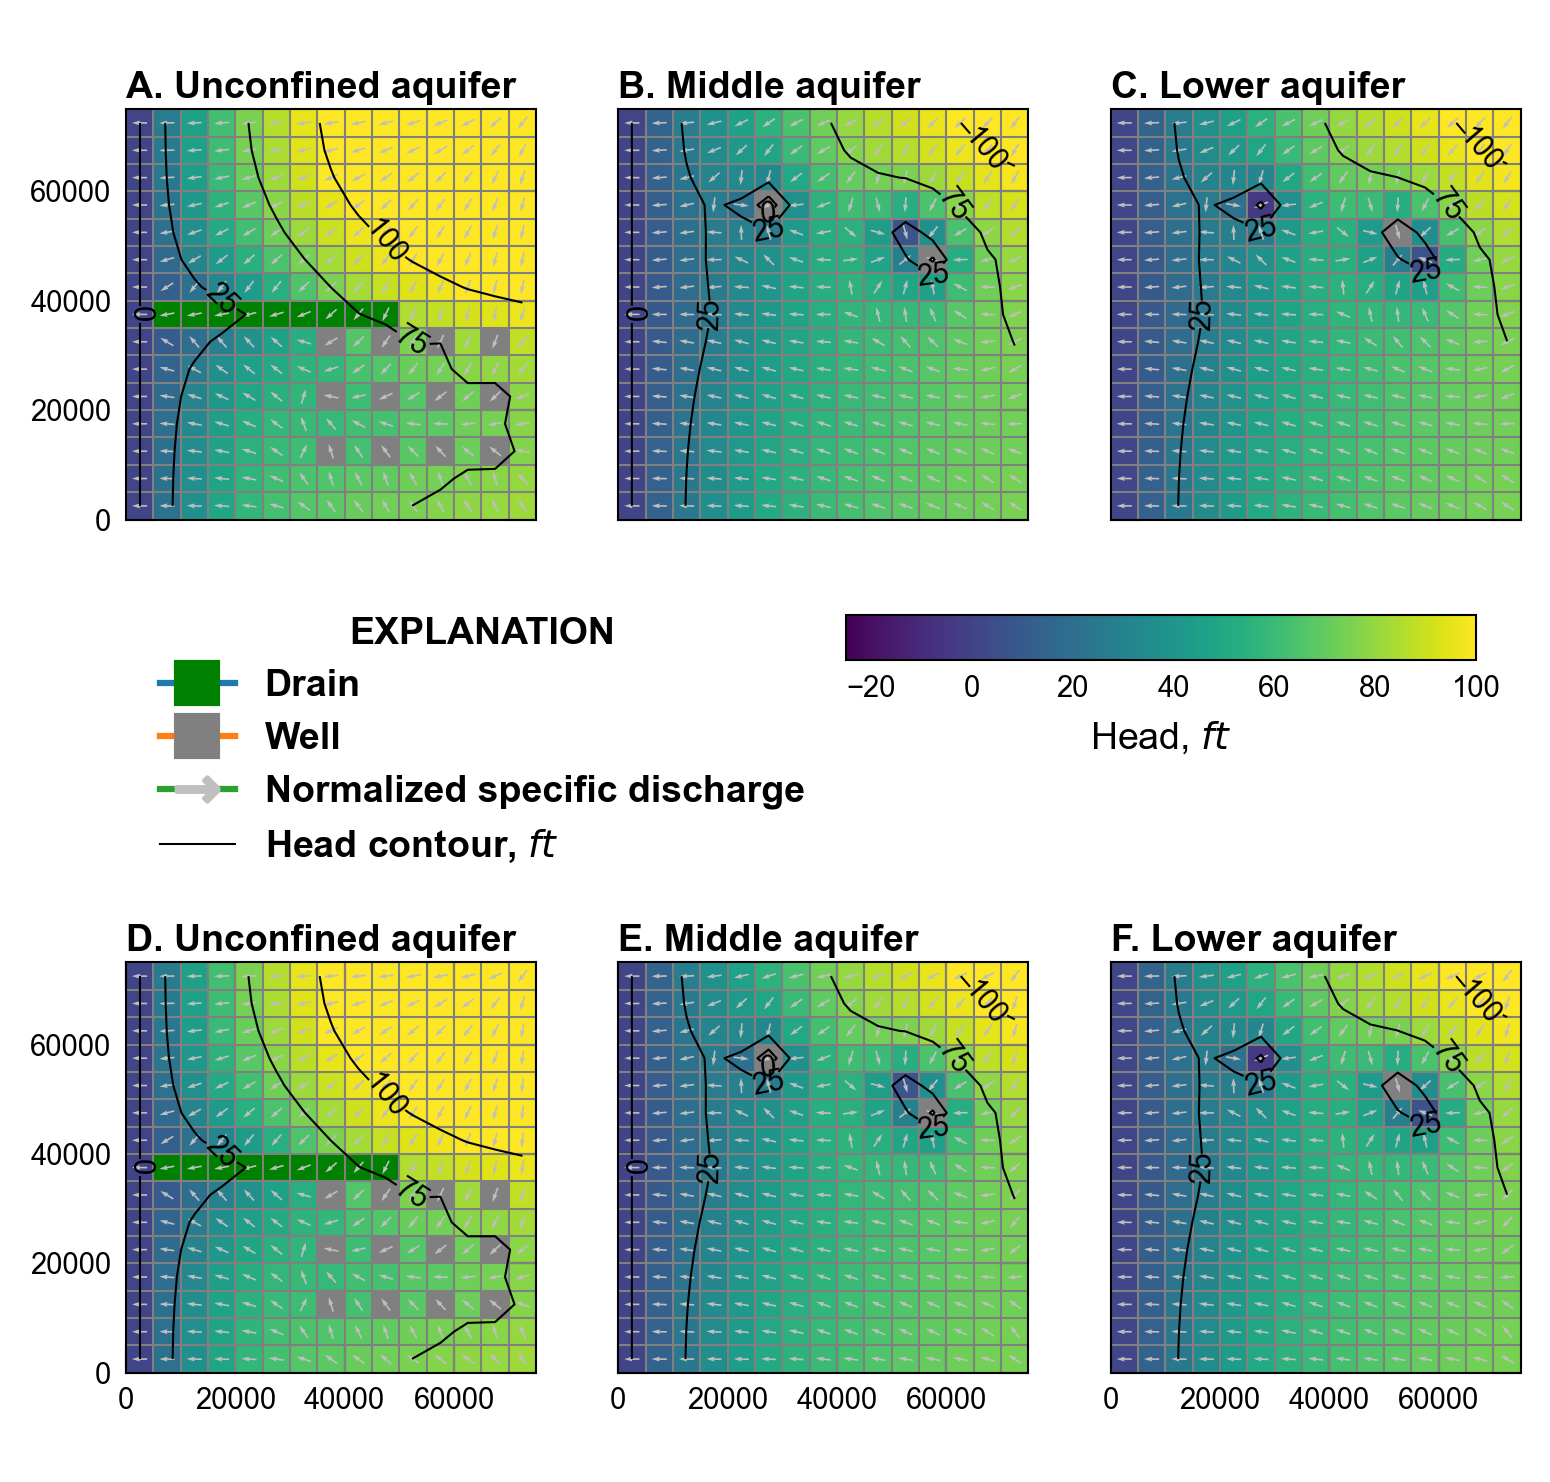

In [5]:
def scenario(silent=True):
    sim = build_models()
    mf = build_mf5model()
    if write:
        write_models(sim, mf, silent=silent)
    if run:
        run_models(sim, mf, silent=silent)
    if plot:
        plot_results(sim, mf, silent=silent)


# Simulated heads in model the unconfined, middle, and lower aquifers (model layers
# 1, 3, and 5) are shown in the figure below. MODFLOW-2005 results for a quasi-3D
# model are also shown. The location of drain (green) and well (gray) boundary
# conditions, normalized specific discharge, and head contours (25 ft contour
# intervals) are also shown.
scenario()